# Materials Data

<div style="background-color: #f8d7da; border-left: 6px solid #ccc; margin: 20px; padding: 15px;">
    <strong>💡 Michael Ashby and David Jones:</strong> How is the engineer to choose from this vast menu the material that best suits the purpose?
</div>

<iframe class="speakerdeck-iframe" frameborder="0" src="https://speakerdeck.com/player/054e4d175cfc4419842d34f0d47a9b8e" title="Machine Learning for Materials (Lecture 3)" allowfullscreen="true" style="border: 0px; background-clip: padding-box; background-color: rgba(0, 0, 0, 0.1); margin: 0px; padding: 0px; border-radius: 6px; box-shadow: rgba(0, 0, 0, 0.2) 0px 5px 40px; width: 50%; height: auto; aspect-ratio: 560 / 420;" data-ratio="1.3333333333333333"></iframe>

[Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-lecture3-ml)

## 🚀 Data-driven thermoelectrics

The goal today is to access, filter, and visualise materials data. You will learn:

- How to access materials databases via Python APIs like *OPTIMADE* and *MPRester*
- How to load and analyse real-world datasets using *matminer*
- How to featurise chemical compositions and visualise them with dimensionality reduction

There is a growing number of open computational materials science databases that include [Materials Project](https://materialsproject.org), [NOMAD](https://nomad-lab.eu), [OQMD](https://oqmd.org), and [AFLOW](http://www.aflowlib.org).

We will use an application programming interface (API) via Python. Open Databases Integration for Materials Design ([OPTIMADE](https://www.optimade.org)) provides access to >20 databases and >20 million structures using a single interface.

<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>🚨 Data warning:</strong> Many computational databases are based on the properties of static crystals. In reality, temperature influences the structures and properties of materials. We have to start somewhere, but keep this in mind when judging the utility of derived models and the trust in "ground truth" reference data.
</div>

In [20]:
# Installation of libraries
!pip install optimade --quiet
!pip install "optimade[http_client]" --quiet
!pip install matminer --quiet
!pip install elementembeddings --quiet
!pip install pymatviz==0.16.0 --quiet
!pip install plotly --quiet

In [21]:
# Import of modules
import pandas as pd  # Data manipulation with DataFrames
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import pprint  # Pretty print data structures
import os  # Operating system functions

<details>
<summary>Colab error solution</summary>
If running the import module cell fails with an "AttributeError", click `Runtime` -> `Restart Session` and then simply rerun the cell.
</details>

## Database queries

In the following Python code, we use OPTIMADE to query a database and retrieve structures that contain a specified number of elements.

The steps include:

* _Initialise the OPTIMADE client:_ specify the database provider.

* _Define a filter:_ set the criteria for filtering the materials data.

* _Retrieve and process data:_ Query the database using the filter and process the retrieved data.

In [22]:
from optimade.client import OptimadeClient

# Initialise with specified provider
client = OptimadeClient(include_providers={"mp"})
   # Other providers include "mp", "alexandria", "oqmd", "jarvis", "aflow"

# Define a filter to find structures with exactly n elements
filters = ['nelements=8']

# Process each filter to fetch and display relevant data
for f in filters:
    # Retrieve data using the client
    result = client.get(f)

    if 'structures' in result and f in result['structures']:
        provider_data = next(iter(result['structures'][f].values()))
        structures_data = provider_data['data']

        # Print the count of structures found
        print(f"Count for filter '{f}': {len(structures_data)}")

        # Print a summary of each structure's ID and formula
        print("Summary of Compounds:")
        for structure in structures_data:
            structure_id = structure.get('id', 'No ID provided')
            formula = structure.get('attributes', {}).get('chemical_formula_descriptive', 'No formula provided')
            print(f"ID: {structure_id}, Formula: {formula}")
    else:
        print("No data found for this filter.")

Output()

Retrieved databases from mp

Output()

╭─────────────────────────────────────────────────╮
│ Performing query structures/?filter=nelements=8 │
╰─────────────────────────────────────────────────╯

Detected a running event loop (e.g., Jupyter). Attempting to switch to synchronous mode.

Count for filter 'nelements=8': 18
Summary of Compounds:
ID: mp-1214950, Formula: Ba2Ce2FeHNaO27Si8Ti2
ID: mp-1221604, Formula: Al4Ca2F8H4Mn2Na4O20P4
ID: mp-1201468, Formula: C4Cl4H24K2N4O8P2Pt2
ID: mp-1221055, Formula: Al6B3H3Mg2NaO31Si6V
ID: mp-863003, Formula: Al6B3FFe3H3NaO30Si6
ID: mp-1221086, Formula: B3Cr3H3Mg3NaO31Si6V3
ID: mp-1201374, Formula: Ag4C12Ca2Cs4H8N12O4S12
ID: mp-1221189, Formula: Ca7F4MnNa5O32Si8TiZr2
ID: mp-1221915, Formula: Ca4F2Fe2Mn2Na4O34Si8Zr4
ID: mp-562835, Formula: C18Cl4Co2Ga2H36N2O6P2
ID: mp-1223707, Formula: Fe2K2Li2Mn2Na4O48Si16Ti4
ID: mp-1224604, Formula: FeK2Li2Mn3Na4O48Si16Ti4
ID: mp-746679, Formula: C16Cl2Co2H48N2O8P4S8
ID: mp-728472, Formula: C16Cl2Fe2H48N2O8P4S8
ID: mp-1213587, Formula: Ba2K4MnNa4O58Si16Ti8W8
ID: mp-707264, Formula: C6Ca6F2H32Na2O50S2U2
ID: mp-1204081, Formula: C32Cu12H96I12Mo4N8O4S12
ID: mp-1204520, Formula: Ag4B40C60Cl8H160N4O12P8


They are complex compounds!

We won't spend too much time delving into the specifics of each API since they each come with their own syntax and capabilities. They can also be slow for complex searches. However, it's important to grasp the overall logic behind constructing queries.

For instance, consider the following example using the Materials Project API. This query is designed to search for materials that contain Li, have a band gap between 0.5 and 1.5 eV, and consist of either two or three elements:

```python
with MPRester(ACCESS_KEY, use_document_model=False) as mpr:
    docs = mpr.materials.summary.search(
        elements=["Li"],
        band_gap=(0.5,1.5),
        num_elements=(2,3),
        fields=['material_id', 'formula_pretty', 'band_gap', 'is_stable', 'theoretical']
       )

print("Number of binary and ternary Li containing compounds with a band gap between 0.5 and 1.5 eV: ", len(docs))
```

Running this requires getting your own [access key](https://next-gen.materialsproject.org/api#api-key). We had problems last year as too many students connected at once and Imperial College got temporarily blocked! For this activity we will move forward and "cheat" by using a pre-built dataset.

## Chemical space of thermoelectric materials

In the Lecture 2 activity, we used a [matminer](https://hackingmaterials.lbl.gov/matminer/) dataset on crystal hardness. Today we will turn to thermoelectric materials.

Thermoelectric devices convert temperature differences directly into electrical voltage, enabling applications in power generation and refrigeration. Their efficiency is characterised by the dimensionless figure of merit (zT), which depends on electrical conductivity, Seebeck coefficient, and thermal conductivity (read more [here](https://www.nature.com/articles/nmat2090)). Let's explore the diverse compositions that give rise to these properties.

In [23]:
import matminer  # Materials informatics
from matminer.datasets.dataset_retrieval import load_dataset  # Load materals datasets

print(matminer.datasets.dataset_retrieval.get_all_dataset_info('ucsb_thermoelectrics'))

Dataset: ucsb_thermoelectrics
Description: Database of ~1,100 experimental thermoelectric materials from UCSB aggregated from 108 source publications and personal communications. Downloaded from Citrine. Source UCSB webpage is http://www.mrl.ucsb.edu:8080/datamine/thermoelectric.jsp. See reference for more information on original data aggregation. No duplicate entries are present, but each src may result in multiple measurements of the same materials' properties at different temperatures or conditions.
Columns:
	composition: Chemical formula.
	crystallinity: Either single crystal, polycrystalline, or nanoparticles.
	synthesis: Brief string describing the synthesis method
	spacegroup: Spacegroup number, if available
	rho (ohm.cm): Electrical resistivity, in ohm.cm
	S [muV/K]: Seebeck coefficient, in microVolts/K, if available
	PF [W/mK^2]: Thermoelectric power factor, conductivity * Seebeck^2, in [W/mK^2] if available
	zT: Thermoelectric figure of merit, PF * T/K, unitless, if available

The dataset is a reasonable size, so we can load it all without downsampling.

In [24]:
# Use matminer to download the dataset
df = load_dataset('ucsb_thermoelectrics')

print(f'The full dataset contains {df.shape[0]} entries. \n')
print('The DataFrame is shown below:')
df.head(10)

The full dataset contains 1093 entries. 

The DataFrame is shown below:


,composition,crystallinity,synthesis,spacegroup,rho (ohm.cm),S [muV/K],PF [W/mK^2],zT,kappa [W/mK],sigma [S/cm],T [K],src
1,Ti0.99Nb0.01NiSn,Polycrystalline,"Arc-melted, vacuum",216.0,0.001240,-192.458,0.002987,0.203822,5.861700,806.390,400.0,http://dx.doi.org/10.1016/j.jallcom.2008.02.041
2,Cu1.98Se,Polycrystalline,"Melted, vacuum",225.0,0.003250,201.500,0.001249,1.230837,1.015000,307.690,1000.0,http://dx.doi.org/10.1038/nmat3280
3,Bi2Te3,Single crystal,Melted,166.0,0.000450,-174.000,0.006728,0.502500,4.016716,2222.200,300.0,http://dx.doi.org/10.1201/9781420049718.ch19
4,Cr1.3Mo6S8,Polycrystalline,"Solid state reaction, vacuum",2.0,0.000693,51.220,0.000378,0.098456,2.690500,1442.400,700.0,http://dx.doi.org/10.1007/s11664-009-0975-0
5,LaNiO3,Polycrystalline,"Evaporate nitrates (1173 K, air)",167.0,0.004601,-25.760,0.000014,NaN,NaN,217.330,700.0,http://dx.doi.org/10.1557/PROC-793-S3.3
6,Bi1.2S1.2Ti2S4,Polycrystalline,"Solid-liquid-vapor reaction, vacuum",NaN,0.000324,-41.300,0.000526,0.053719,2.940000,3086.400,300.0,http://dx.doi.org/10.3390/ma3042606
7,Ba0.4Sr0.6PbO3,Polycrystalline,Solid state reaction (under oxygen),62.0,0.004128,-82.770,0.000166,0.021697,2.294800,242.260,300.0,http://dx.doi.org/10.1023/A:1018515223271
8,SrTi0.8Nb0.2O3,Polycrystalline,"Solid state reaction, Ar",140.0,0.001420,-62.400,0.000274,0.012720,8.620000,704.000,400.0,http://dx.doi.org/10.1063/1.3117943
9,CaMn0.98Ru0.02O3,Polycrystalline,Solid state reaction,62.0,0.024183,-195.780,0.000159,NaN,NaN,41.352,700.0,http://dx.doi.org/10.1016/S0025-5408(02)00997-2
10,Mg2Si0.997Bi0.003,Polycrystalline,"Mechanochemical, Ar",225.0,0.000488,-76.600,0.001202,0.058557,6.160000,2049.200,300.0,http://dx.doi.org/10.1039/C1JM10827A


<details>
<summary> If the previous cell didn't work </summary>
If there was an error when downloading the data using matminer, go to `https://figshare.com/ndownloader/files/28333845`, which will download the data. Then run the following code in a new cell:

```
import gzip, json
import pandas as pd
from pathlib import Path

path = Path.home() / "Downloads" / "ucsb_thermoelectrics.json.gz"

with gzip.open(path, "rt") as f:
    obj = json.load(f)

df = pd.DataFrame(obj["data"], index=obj["index"], columns=obj["columns"])
df.head()
```
</details>

Let's perform a deeper check of the DataFrame to understand its structure and contents.

In [25]:
# Display the columns of the dataset
print("Columns in the dataset:")
print(df.columns)

# Check for any missing values in the dataset
print("\nChecking for missing values:")
print(df.isnull().sum())

Columns in the dataset:
Index(['composition', 'crystallinity', 'synthesis', 'spacegroup',
       'rho (ohm.cm)', 'S [muV/K]', 'PF [W/mK^2]', 'zT', 'kappa [W/mK]',
       'sigma [S/cm]', 'T [K]', 'src'],
      dtype='object')

Checking for missing values:
composition        0
crystallinity      0
synthesis          8
spacegroup        13
rho (ohm.cm)       0
S [muV/K]          0
PF [W/mK^2]        0
zT               379
kappa [W/mK]     379
sigma [S/cm]       0
T [K]             11
src                7
dtype: int64


<details>
<summary> Code hint </summary>
Check the DataFrame name
</details>

First, let's visualise the distribution of the zT performance metric in the dataset. This will help us understand the range and common values.

In [26]:
df.columns

Index(['composition', 'crystallinity', 'synthesis', 'spacegroup',
       'rho (ohm.cm)', 'S [muV/K]', 'PF [W/mK^2]', 'zT', 'kappa [W/mK]',
       'sigma [S/cm]', 'T [K]', 'src'],
      dtype='object')

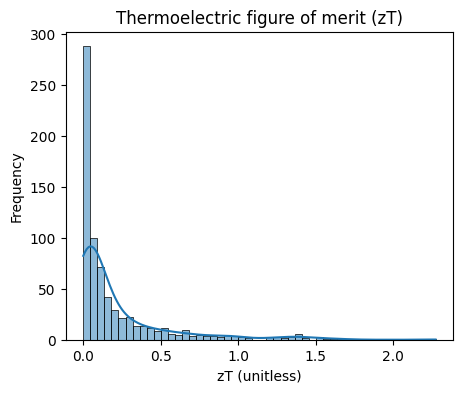

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of zT values
plt.figure(figsize=(5, 4))
sns.histplot(df['zT'], bins=50, kde=True)
plt.title('Thermoelectric figure of merit (zT)')
plt.xlabel('zT (unitless)')
plt.ylabel('Frequency')
plt.show()

<details>
<summary> Code hint </summary>
Set the number of bins for the histogram. 50?</details>

Next, we will analyse the distribution of elements within our thermoelectrics dataset by creating a heatmap over the periodic table. This would take a lot of time from scratch, but we can use the [pymatviz](https://github.com/janosh/pymatviz) package.

In [28]:
# Check version of package pymatviz
import pymatviz
print("Version of pymatviz:", pymatviz.__version__)

Version of pymatviz: 0.16.0


In [29]:
import re
from collections import Counter
from pymatviz import ptable_heatmap_plotly

# Function to extract elements using a regex pattern
def extract_elements(composition):
    # Regex to match chemical elements: one uppercase letter optionally followed by a lowercase letter
    pattern = r"[A-Z][a-z]?"
    return re.findall(pattern, composition)

# Extract all unique elements from the composition column
elements = []
for composition in df['composition']:
    elements += extract_elements(composition)

# Count the frequency of each element
element_counts = Counter(elements)

# Convert the Counter object to a dictionary for the heatmap
element_counts_dict = dict(element_counts)

# Create the periodic table heatmap
fig = ptable_heatmap_plotly(
    element_counts_dict,
    colorscale="viridis",
    log=True,  # Use logarithmic scale for better visualisation
    fmt=".0f", # Formatting of heat labels using integer numbers
    font_size=10,
    colorbar={"title": "Frequency of Elements"}
)

# Add a title
fig.update_layout(title_text="Element Frequency in Thermoelectric Dataset", title_x=0.5, title_font_size=18)

# Display the plot
fig.show()

## Unsupervised machine learning

We have a set of materials with different compositions. We can use machine learning to visualise these in two or three dimensions. You can think of this like a materials map.

We refer to the methods that enable us to reduce high-dimensional data into lower dimensions as [dimensionality reduction techniques](https://scikit-learn.org/stable/modules/manifold.html). These allow us to visualise complex data and in this example we will make use of Principal Component Analysis (PCA).

<details>
<summary> Overview of PCA </summary>
PCA is a popular technique for dimensionality reduction and data preprocessing, enabling the simplification of complex datasets. High-dimensional data is transformed into a new coordinate system where the axes align with the directions of maximum variance in the original data. These new axes, termed "principal components," are orthogonal. The first principal component captures the highest variance, the second captures the second highest, etc.

_Key use cases include:_

- **Dimensionality Reduction**: Identifying and eliminating less informative dimensions, reducing noise and computational complexity.

- **Data Visualisation**: Facilitating easier interpretation while preserving essential patterns.

- **Noise Reduction**: Filtering out noise or unimportant variations by focusing on significant variance.

- **Feature Engineering**: A preprocessing step to transform data before applying machine learning algorithms, potentially improving performance.

_PCA workflow:_

1. **Center the Data**: Subtract the mean from each feature to center the data around the origin.

   $
   X_{\text{centered}} = X - \bar{X}
   $

2. **Calculate Covariance Matrix**: Compute the covariance matrix to understand feature relationships and their [covariance](https://en.wikipedia.org/wiki/Covariance).

   $
   \text{Cov}(X) = \frac{1}{n}X_{\text{centered}}^T X_{\text{centered}}
   $

3. **Compute Eigenvalues and Eigenvectors**: Calculate eigenvalues ($\lambda_i$) and eigenvectors ($\mathbf{v}_i$) of the covariance matrix. Eigenvectors represent maximum variance directions, and eigenvalues quantify the variance magnitude.

   $
   \text{Cov}(X) \mathbf{v}_i = \lambda_i \mathbf{v}_i
   $

4. **Sort Eigenvalues**: Sort eigenvalues in descending order, rearranging corresponding eigenvectors accordingly.

5. **Select Principal Components**: Choose a subset of eigenvectors (principal components) based on eigenvalues, explaining the most variance in the data.

6. **Project Data**: Project original data onto selected principal components, yielding a lower-dimensional representation.

Note that PCA analysis is limited by its reliance on linear transformations of the data. In cases where non-linear structures are prominent, alternative techniques such as t-distributed Stochastic Neighbor Embedding (t-SNE) can be used.
</details>

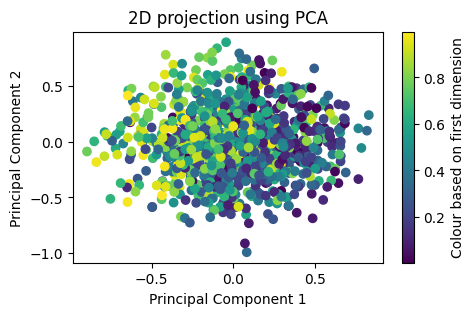

In [30]:
# Perform PCA analysis
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

plt.rcdefaults() # Reset the matplotlib style

# Random 10D vectors for demonstration purposes
np.random.seed(42)
num_samples = 1000
dimensionality = 2 # Set the dimensionality to 2 for a 2D projection
random_state = 42
data = np.random.rand(num_samples, 10) # num_samples vectors of 10 dimensions each

# Perform PCA to reduce the dimensionality to 2D
pca = PCA(n_components=dimensionality)
reduced_data = pca.fit_transform(data)

# Create a color map based on the original data points
   # Use the first dimension of the original data as the color value
color_map = data[:, 0]

# Plot the 2D projection
plt.figure(figsize=(5, 3))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=color_map, cmap='viridis')
plt.colorbar(label='Colour based on first dimension')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D projection using PCA')
plt.show()

<details>
<summary> Code hint </summary>
Set the number of dimensions (components) to 2
</details>

#### Featurise compositions

Using our dataset, we can try different featurisation schemes and analyse the resulting visualisations. Here we will perform a Magpie encoding of chemical compositions using the [ElementEmbeddings](https://github.com/WMD-group/ElementEmbeddings) package.

In [31]:
from elementembeddings.composition import composition_featuriser

magpie_df = composition_featuriser(df, formula_column="composition", embedding='magpie')
magpie_df.head()

Featurising compositions...


100%|██████████| 1093/1093 [00:06<00:00, 157.28it/s]


Computing feature vectors...


100%|██████████| 1093/1093 [00:00<00:00, 36888.65it/s]


,composition,crystallinity,synthesis,spacegroup,rho (ohm.cm),S [muV/K],PF [W/mK^2],zT,kappa [W/mK],sigma [S/cm],...,mean_NValence,mean_NsUnfilled,mean_NpUnfilled,mean_NdUnfilled,mean_NfUnfilled,mean_NUnfilled,mean_GSvolume_pa,mean_GSbandgap,mean_GSmagmom,mean_SpaceGroupNumber
1,Ti0.99Nb0.01NiSn,Polycrystalline,"Arc-melted, vacuum",216.0,0.001240,-192.458,0.002987,0.203822,5.861700,806.39,...,12.677852,0.664430,0.671141,0.000000,0.0,1.335570,16.053221,0.268121,0.000000,154.194631
2,Cu1.98Se,Polycrystalline,"Melted, vacuum",225.0,0.003250,201.500,0.001249,1.230837,1.015000,307.69,...,21.200000,0.000000,2.400000,0.000000,0.0,2.400000,34.038000,0.278400,0.000000,96.000000
3,Bi2Te3,Single crystal,Melted,166.0,0.000450,-174.000,0.006728,0.502500,4.016716,2222.20,...,6.000000,0.477124,1.045752,2.385621,0.0,3.908497,20.587059,1.151373,0.000000,145.862745
4,Cr1.3Mo6S8,Polycrystalline,"Solid state reaction, vacuum",2.0,0.000693,51.220,0.000378,0.098456,2.690500,1442.40,...,6.200000,0.000000,1.200000,2.200000,0.0,3.400000,14.906500,0.000000,0.119079,91.000000
5,LaNiO3,Polycrystalline,"Evaporate nitrates (1173 K, air)",167.0,0.004601,-25.760,0.000014,NaN,NaN,217.33,...,8.809524,0.000000,1.666667,1.904762,0.0,3.571429,24.644256,1.363143,0.000005,91.238095


In [32]:
from elementembeddings.composition import composition_featuriser

magpie_df = composition_featuriser(df, formula_column="composition", embedding='magpie')
magpie_df.head()

Featurising compositions...


100%|██████████| 1093/1093 [00:08<00:00, 122.72it/s]


Computing feature vectors...


100%|██████████| 1093/1093 [00:00<00:00, 34918.99it/s]


,composition,crystallinity,synthesis,spacegroup,rho (ohm.cm),S [muV/K],PF [W/mK^2],zT,kappa [W/mK],sigma [S/cm],...,mean_NValence,mean_NsUnfilled,mean_NpUnfilled,mean_NdUnfilled,mean_NfUnfilled,mean_NUnfilled,mean_GSvolume_pa,mean_GSbandgap,mean_GSmagmom,mean_SpaceGroupNumber
1,Ti0.99Nb0.01NiSn,Polycrystalline,"Arc-melted, vacuum",216.0,0.001240,-192.458,0.002987,0.203822,5.861700,806.39,...,12.677852,0.664430,0.671141,0.000000,0.0,1.335570,16.053221,0.268121,0.000000,154.194631
2,Cu1.98Se,Polycrystalline,"Melted, vacuum",225.0,0.003250,201.500,0.001249,1.230837,1.015000,307.69,...,21.200000,0.000000,2.400000,0.000000,0.0,2.400000,34.038000,0.278400,0.000000,96.000000
3,Bi2Te3,Single crystal,Melted,166.0,0.000450,-174.000,0.006728,0.502500,4.016716,2222.20,...,6.000000,0.477124,1.045752,2.385621,0.0,3.908497,20.587059,1.151373,0.000000,145.862745
4,Cr1.3Mo6S8,Polycrystalline,"Solid state reaction, vacuum",2.0,0.000693,51.220,0.000378,0.098456,2.690500,1442.40,...,6.200000,0.000000,1.200000,2.200000,0.0,3.400000,14.906500,0.000000,0.119079,91.000000
5,LaNiO3,Polycrystalline,"Evaporate nitrates (1173 K, air)",167.0,0.004601,-25.760,0.000014,NaN,NaN,217.33,...,8.809524,0.000000,1.666667,1.904762,0.0,3.571429,24.644256,1.363143,0.000005,91.238095


Note all of the extra columns that have been added containing the features. We need to do a little cleanup of the DataFrame and can then proceed with our PCA analysis.

Shape of new features DataFrame after dropping old columns and NaNs: (1093, 22)


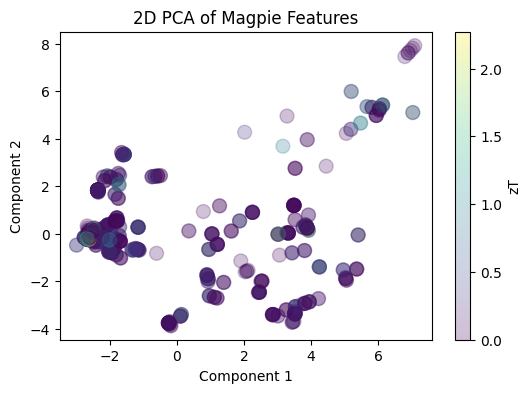

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select only the new features by dropping the original columns and handling NaNs
new_features_df = magpie_df.drop(columns=df.columns).dropna()
print(f"Shape of new features DataFrame after dropping old columns and NaNs: {new_features_df.shape}")

# Extract feature values
X = new_features_df.values
X_standardised = StandardScaler().fit_transform(X)

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_standardised)

# Create a single plot for visualisation
fig, ax = plt.subplots(figsize=(6, 4))

# Select a label for coloring (assuming zT column exists in the original df)
color_map = df["zT"].values  # Use original DataFrame for the label (e.g., zT)

# Scatter plot in 2D space
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=color_map, cmap='viridis', alpha=0.25, s=100)

# Add labels and title
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("2D PCA of Magpie Features")

# Add colour bar
fig.colorbar(scatter, ax=ax, label="zT")

# Show the plot
plt.show()

Let’s check how much variance is captured by the first two principal components. Capturing above 50% of the variance with two dimensions is generally acceptable for initial exploration. However, for practical applications, we might need to increase the number of components to explain a higher proportion of the variance (e.g. 80%-90%) to ensure sufficient representation of the data.

In [34]:
# Check explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
print(f"Explained variance by Component 1: {explained_variance[0]:.2f}")
print(f"Explained variance by Component 2: {explained_variance[1]:.2f}")
print(f"Cumulative variance explained by 2 components: {cumulative_variance[1]:.2f}")

Explained variance by Component 1: 0.35
Explained variance by Component 2: 0.20
Cumulative variance explained by 2 components: 0.55



Now, wouldn't it be nice if we could see what material each data point refers to. [Plotly](https://plotly.com/python/) can help with that.

In [35]:
import plotly.express as px

# Add the zT column and composition column from the original DataFrame for coloring and hover info
plot_df = pd.DataFrame(reduced_data, columns=['Component 1', 'Component 2'])
plot_df['zT'] = df['zT'].values
plot_df['composition'] = df['composition'].values  # Assuming this is the column with chemical formulas

# Create an interactive scatter plot using Plotly
fig = px.scatter(
    plot_df,
    x='Component 1',
    y='Component 2',
    color='zT',
    color_continuous_scale='Viridis',
    opacity=0.6,
    hover_name='composition',  # Show chemical formula on hover
    hover_data={'Component 1': ':.2f', 'Component 2': ':.2f', 'zT': ':.2f'},  # Additional hover data
    labels={'zT': 'zT Value'}
)

fig.update_traces(marker=dict(size=10))  # Adjust the size value as needed

fig.update_layout(
    width=6*96,  # 6 inches converted to pixels
    height=4*96  # 4 inches converted to pixels
)

# Show the interactive plot
fig.show()

Finally, let's see how a 3D projection looks.

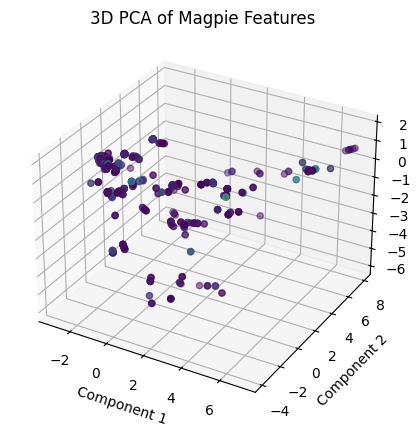

In [36]:
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(X_standardised)

# Create a 3D plot for visualisation
fig = plt.figure(figsize=(6, 5))

# Create a 3D plot
ax = fig.add_subplot(111, projection='3d')
color_map = df["zT"].values
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=color_map, cmap='viridis', alpha=0.5)

# Add labels and title
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title("3D PCA of Magpie Features")

# Show the plot
plt.show()

<details>
<summary> Code hint </summary>
You can change the featurisation scheme to see the impact on the resulting visualisation and distribution of compositions
</details>

## 🚨 Exercise 3

<div style="background-color: #dceefb; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>💡 Coding exercises:</strong> The exercises are designed to apply what you have learned with room for creativity. It is fine to discuss solutions with your classmates, but the actual code should not be directly copied.
</div>

### Your details

In [41]:
import numpy as np

# Insert your values
Name = "Hanzhi Zhu" # Replace with your name
CID = 2243276 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

This is the work of Hanzhi Zhu [CID: 2243276]


### 🧪 Problem: Composition Features and Dimensionality Reduction

In this activity, you'll explore how unsupervised learning can reveal patterns in materials data, particularly for thermoelectric materials. By featurising chemical compositions and applying dimensionality reduction techniques, we can visualise chemical trends and cluster similar materials.

Tasks will be introduced in class.

In [49]:
# Task 1
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
print(f"Explained variance by Component 1: {explained_variance[0]:.2f}")
print(f"Explained variance by Component 2: {explained_variance[1]:.2f}")
print(f"Cumulative variance explained by 2 components: {cumulative_variance[1]:.2f}")
import plotly.express as px
from sklearn.decomposition import PCA

# Re-perform 2D PCA to ensure reduced_data has 2 components for this 2D plot
pca_2d = PCA(n_components=2)
reduced_data_2d = pca_2d.fit_transform(X_standardised)

# Add the zT column and composition column from the original DataFrame for coloring and hover info
plot_df = pd.DataFrame(reduced_data_2d, columns=['Component 1', 'Component 2'])
plot_df['zT'] = df['zT'].values
plot_df['composition'] = df['composition'].values  # Assuming this is the column with chemical formulas

# Create an interactive scatter plot using Plotly
fig = px.scatter(
    plot_df,
    x='Component 1',
    y='Component 2',
    color='zT',
    color_continuous_scale='Viridis',
    opacity=0.6,
    hover_name='composition',  # Show chemical formula on hover
    hover_data={'Component 1': ':.2f', 'Component 2': ':.2f', 'zT': ':.2f'},  # Additional hover data
    labels={'zT': 'zT Value'}
)

fig.update_traces(marker=dict(size=10))  # Adjust the size value as needed

fig.update_layout(
    width=6*96,  # 6 inches converted to pixels
    height=4*96  # 4 inches converted to pixels
)

# Show the interactive plot
fig.show()

Explained variance by Component 1: 0.35
Explained variance by Component 2: 0.20
Cumulative variance explained by 2 components: 0.55


In [56]:
# Task 2
print("No obvious high zT cluster is shown in figure above. However, a region with relatively higher zT values is observed in the upper-right part of the PCA map (high PC1 and PC2), for example around compositions such as In0.2Co4Sb12. Compared to the left cluster, this region contains more moderate-to-high performing thermoelectric materials. These compositions typically involve heavy elements and complex bonding environments, which enhance phonon scattering and reduce lattice thermal conductivity. As a result, this chemical region is more favourable for thermoelectric performance.")

No obvious high zT cluster is shown in figure above. However, a region with relatively higher zT values is observed in the upper-right part of the PCA map (high PC1 and PC2), for example around compositions such as In0.2Co4Sb12. Compared to the left cluster, this region contains more moderate-to-high performing thermoelectric materials. These compositions typically involve heavy elements and complex bonding environments, which enhance phonon scattering and reduce lattice thermal conductivity. As a result, this chemical region is more favourable for thermoelectric performance.


In [54]:
#Task 3

!pip install -q matminer elementembeddings plotly scikit-learn


import pandas as pd
import numpy as np

from matminer.datasets.dataset_retrieval import load_dataset
from elementembeddings.composition import composition_featuriser

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import plotly.express as px

df = load_dataset("ucsb_thermoelectrics")
df = df.reset_index(drop=True) # Add this line to reset the DataFrame index
print("Dataset shape:", df.shape)

# featurise -> clean -> align -> scale -> PCA -> plotly
def run_pca_pipeline(df, embedding_name="mat2vec", n_components=2):
    """
    Runs: composition featurisation -> remove NaNs -> align zT/composition -> scale -> PCA.
    Returns: plot_df (PCs + zT + composition), explained_variance_ratio
    """

    # Featurise compositions (embedding can be: "magpie", "mat2vec", "oliynyk", "onehot")
    feat_df = composition_featuriser(
        df,
        formula_column="composition",
        embedding=embedding_name
    )

    # Keep only the new feature columns (drop original dataset columns)
    X_df = feat_df.drop(columns=feat_df.columns.intersection(df.columns))


    # Drop rows with NaNs (PCA cannot handle NaNs)
    X_df = X_df.dropna()

    # Align original labels with remaining rows
    aligned = df.loc[X_df.index].copy()

    # Scale features (important before PCA)
    X = X_df.values
    X_scaled = StandardScaler().fit_transform(X)

    # PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Build plotting dataframe
    pc_cols = [f"PC{i+1}" for i in range(n_components)]
    plot_df = pd.DataFrame(X_pca, columns=pc_cols)
    plot_df["zT"] = aligned["zT"].values
    plot_df["composition"] = aligned["composition"].values

    return plot_df, pca.explained_variance_ratio_


# Run PCA with mat2vec
plot_mat2vec, ev_mat2vec = run_pca_pipeline(df, embedding_name="mat2vec", n_components=2)

print("\n[mat2vec] Explained variance ratio:", ev_mat2vec)
print("[mat2vec] Cumulative (2 PCs):", float(np.sum(ev_mat2vec)))

fig = px.scatter(
    plot_mat2vec,
    x="PC1",
    y="PC2",
    color="zT",
    hover_name="composition",
    opacity=0.7,
    color_continuous_scale="Viridis",
    title="PCA (2D) using mat2vec composition features"
)
fig.update_traces(marker=dict(size=9))
fig.update_layout(width=900, height=520)
fig.show()


# Compare with Magpie
plot_magpie, ev_magpie = run_pca_pipeline(df, embedding_name="magpie", n_components=2)

print("\n[magpie] Explained variance ratio:", ev_magpie)
print("[magpie] Cumulative (2 PCs):", float(np.sum(ev_magpie)))

fig2 = px.scatter(
    plot_magpie,
    x="PC1",
    y="PC2",
    color="zT",
    hover_name="composition",
    opacity=0.7,
    color_continuous_scale="Viridis",
    title="PCA (2D) using Magpie composition features"
)
fig2.update_traces(marker=dict(size=9))
fig2.update_layout(width=900, height=520)
fig2.show()

def quadrant_mean_zT(plot_df):
    pc1_med = plot_df["PC1"].median()
    pc2_med = plot_df["PC2"].median()
    q = plot_df[(plot_df["PC1"] > pc1_med) & (plot_df["PC2"] > pc2_med)]
    return float(q["zT"].mean()), int(q.shape[0])

m_mean, m_n = quadrant_mean_zT(plot_mat2vec)
g_mean, g_n = quadrant_mean_zT(plot_magpie)

print("\nHeuristic (top-right quadrant mean zT):")
print(f"mat2vec: mean zT = {m_mean:.3f} (n={m_n})")
print(f"magpie : mean zT = {g_mean:.3f} (n={g_n})")

Dataset shape: (1093, 12)
Featurising compositions...


100%|██████████| 1093/1093 [00:17<00:00, 62.03it/s]


Computing feature vectors...


100%|██████████| 1093/1093 [00:00<00:00, 120182.84it/s]



[mat2vec] Explained variance ratio: [0.31441923 0.14706195]
[mat2vec] Cumulative (2 PCs): 0.46148117763344243


Featurising compositions...


100%|██████████| 1093/1093 [00:02<00:00, 420.61it/s]


Computing feature vectors...


100%|██████████| 1093/1093 [00:00<00:00, 125180.88it/s]



[magpie] Explained variance ratio: [0.35292394 0.19566608]
[magpie] Cumulative (2 PCs): 0.548590018035708



Heuristic (top-right quadrant mean zT):
mat2vec: mean zT = 0.091 (n=206)
magpie : mean zT = 0.399 (n=249)


In [55]:
print("The mat2vec representation shows clearer cluster separation compared to Magpie, suggesting improved grouping of chemically similar materials. Magpie produces a smoother distribution that reflects continuous variations in elemental properties. Overall, mat2vec provides better clustering behaviour, while Magpie offers stronger interpretability.")

The mat2vec representation shows clearer cluster separation compared to Magpie, suggesting improved grouping of chemically similar materials. Magpie produces a smoother distribution that reflects continuous variations in elemental properties. Overall, mat2vec provides better clustering behaviour, while Magpie offers stronger interpretability.


<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>📓 Submission:</strong> When your notebook is complete in Google Colab, go to <em>File > Download</em> and choose <code>.ipynb</code>. The completed file should be uploaded to Blackboard under assignments for MATE70026.
</div>

## 🌊 Dive deeper

* _Level 1:_ Tackle Chapter 8 on Linear Unsupervised Learning in [Machine Learning Refined](https://github.com/jermwatt/machine_learning_refined#what-is-new-in-the-second-edition).

* _Level 2:_ Read about our attempt to screen _all inorganic materials_ (with caveats) in the journal [Chem](https://doi.org/10.1016/j.chempr.2016.09.010).

* _Level 3:_ Watch a [seminar](https://www.youtube.com/watch?v=gd-uahI5xbA) by quantum chemist Anatole von Lilienfeld on chemical space.